In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.constants import *
from main_code.utils.CosmoFunc import *
from main_code.utils.functions import bin_data, bin_data_median, bin_data_error_weighting

# Reproduce Figure A1 in Paula's paper

/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_9025/69055217.py:16: RuntimeWarning: invalid value encountered in log10
  logdists = np.log10(D_z / D_c)


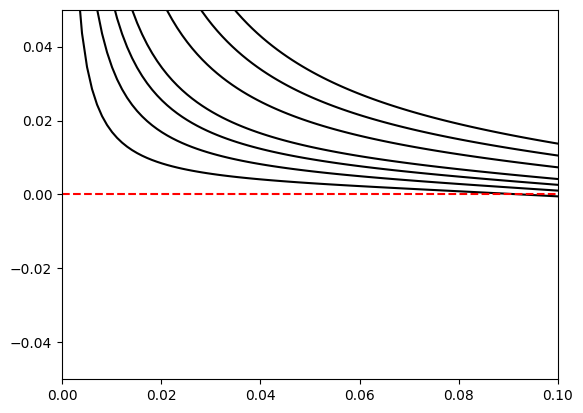

In [2]:
for v_p in [100., 200., 300., 400., 600., 800., 1000]:
    # Set the peculiar velocity
    # v_p = 100.0
    z_p = v_p / LightSpeed

    # Observed redshift
    z = np.linspace(0., 0.1, 100)

    # Cosmological redshift
    z_c = (z - z_p) / (1 + z_p)

    # Calculate distances
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table(H0=100)
    D_z = sp.interpolate.splev(z, dist_spline)
    D_c = sp.interpolate.splev(z_c, dist_spline)
    logdists = np.log10(D_z / D_c)

    # Calculate v_p estimator
    v_p_approx = LightSpeed * z * logdists * np.log(10) / (1 + 0.75 * z)

    # Calculate relative error
    epsilon = (v_p_approx - v_p) / np.abs(v_p)

    # Plot
    plt.plot(z, epsilon, c='k')

plt.ylim(-0.05, 0.05)
plt.xlim(0., 0.1)
plt.axhline(y=0., c='r', ls='--')
plt.show()

# Calculate 6dFGS, SDSS, and LAMOST PV bias vs redshift

Use equation A6 from Boubel et al. (2024)

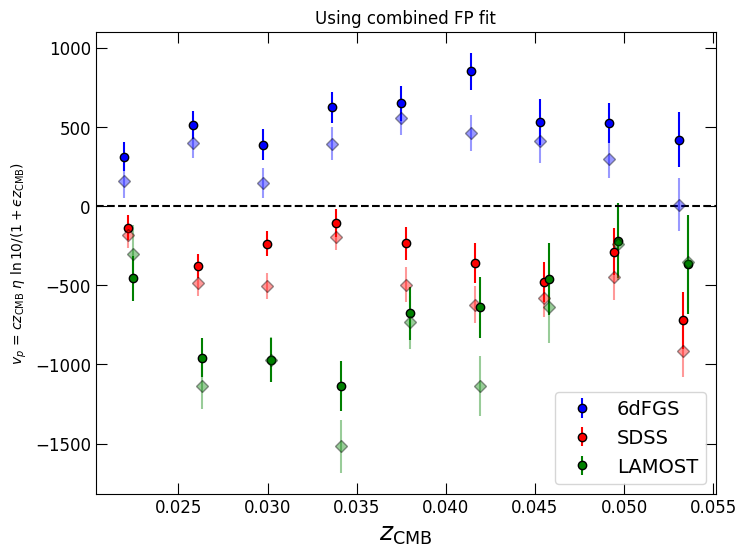

In [24]:
epsilon = 0.75
method = "combined"

colors = ["blue", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 6))

# Load data
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../../data/foundation/distance_modulus/{survey.lower()}.csv")

    # Get error-weighted average in bins
    x = df["z_dist_est"].to_numpy()
    y = df[f"logdist_{method}_fp"].to_numpy()
    yerr = df[f"logdist_err_{method}_fp"].to_numpy()

    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.02, 0.055, 10)

    # Calculate peculiar velocity estimator
    pv = LightSpeed * x_bin * y_bin * np.log(10) / (1 + epsilon * x_bin)
    pv_err = LightSpeed * x_bin * y_bin_stderr * np.log(10) / (1 + epsilon * x_bin)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, pv, yerr=pv_err, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=survey)


    # Get median in bins
    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_median(x, y, 0.02, 0.055, 10)

    # Calculate peculiar velocity estimator
    pv = LightSpeed * x_bin * y_bin * np.log(10) / (1 + epsilon * x_bin)
    pv_err = LightSpeed * x_bin * y_bin_stderr * np.log(10) / (1 + epsilon * x_bin)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, pv, yerr=pv_err, fmt="D", mec='k', mfc=colors[i], ecolor=colors[i], alpha=0.4)

ax.legend(loc="lower right", fontsize=14)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax.set_ylabel(r"$v_p$ = $cz_\mathrm{CMB}\ \eta\ \ln 10$/($1+ϵ z_\mathrm{CMB}$)", fontsize=10)
ax.set_title(f"Using {method} FP fit")

ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)


## Calculate PV first

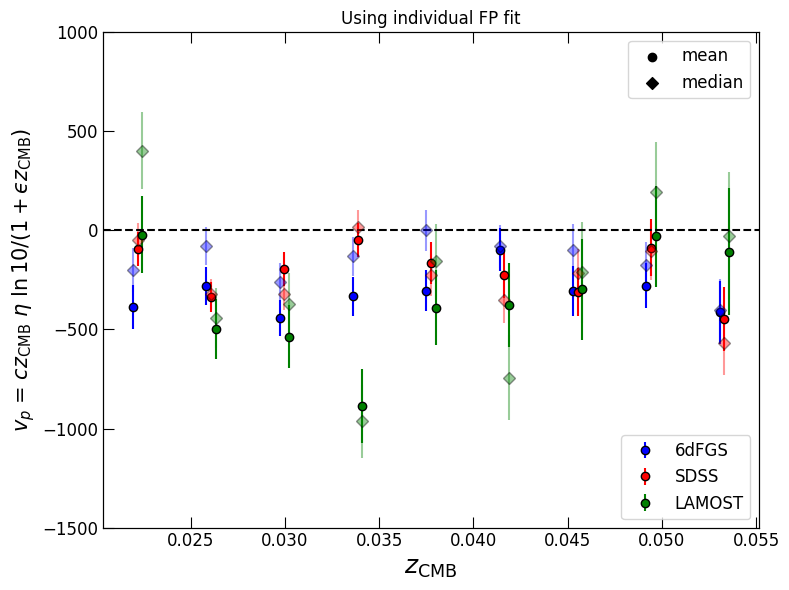

In [40]:
epsilon = 0.75
method = "individual"
z_col = "z_dist_est"

colors = ["blue", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 6))

# Load data
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../../data/foundation/distance_modulus/{survey.lower()}.csv")
    df["pv"] = LightSpeed * df[z_col] * df[f"logdist_{method}_fp"] * np.log(10) / (1 + epsilon * df[z_col])
    df["pv_err"] = LightSpeed * df[z_col] * df[f"logdist_err_{method}_fp"] * np.log(10) / (1 + epsilon * df[z_col])

    # Get error-weighted average in bins
    x = df[z_col].to_numpy()
    y = df[f"pv"].to_numpy()
    yerr = df[f"pv_err"].to_numpy()

    # # Mean
    x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = bin_data(x, y, 0.02, 0.055, 10)

    # # Error-weighted average
    # x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.02, 0.055, 10)

    # Median bin
    x_bin, y_median_bin, y_median_bin_err, y_median_bin_stderr = bin_data_median(x, y, 0.02, 0.055, 10)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=survey)
    ax.errorbar(x_bin + i * 0.00025, y_median_bin, yerr=y_median_bin_stderr, fmt="D", mec='k', mfc=colors[i], ecolor=colors[i], alpha=0.4)

# ax.legend(loc="lower right", fontsize=14)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax.set_ylabel(r"$v_p$ = $cz_\mathrm{CMB}\ \eta\ \ln 10$/($1+ϵ z_\mathrm{CMB}$)", fontsize=15)
ax.set_title(f"Using {method} FP fit")

ax.set_ylim(-1500, 1000)
ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

# Ghost axis
styles = ['-', '--', '-.']
ax2 = ax.twinx()
ax2.scatter(np.NaN, np.NaN, marker='o', label='mean', c='black')
ax2.scatter(np.NaN, np.NaN, marker='D', label='median', c='black')
ax2.get_yaxis().set_visible(False)

ax.legend(loc="lower right", fontsize=12)
ax2.legend(loc=1, fontsize=12)

fig.tight_layout()
fig.savefig(f"./{method}_fp_bias.png", bbox_inches='tight', dpi=300)

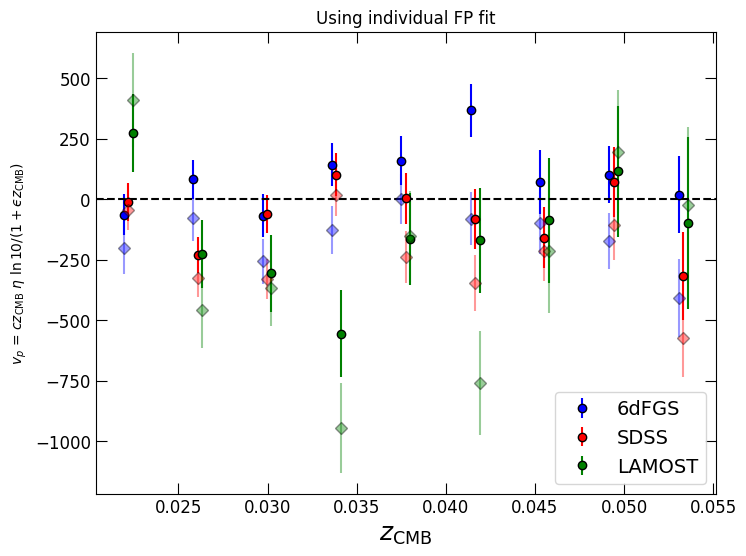

In [25]:
epsilon = 0.75
method = "individual"

colors = ["blue", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 6))

# Load data
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../../data/foundation/distance_modulus/{survey.lower()}.csv")

    # Get error-weighted average in bins
    x = df["z_dist_est"].to_numpy()
    y = df[f"logdist_{method}_fp"].to_numpy()
    yerr = df[f"logdist_err_{method}_fp"].to_numpy()

    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.02, 0.055, 10)

    # Calculate peculiar velocity estimator
    pv = LightSpeed * x_bin * y_bin * np.log(10) / (1 + epsilon * x_bin)
    pv_err = LightSpeed * x_bin * y_bin_stderr * np.log(10) / (1 + epsilon * x_bin)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, pv, yerr=pv_err, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=survey)


    ############################################################################################################
    # Get median in bins
    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_median(x, y, 0.02, 0.055, 10)

    # Calculate peculiar velocity estimator
    pv = LightSpeed * x_bin * y_bin * np.log(10) / (1 + epsilon * x_bin)
    pv_err = LightSpeed * x_bin * y_bin_stderr * np.log(10) / (1 + epsilon * x_bin)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, pv, yerr=pv_err, fmt="D", mec='k', mfc=colors[i], ecolor=colors[i], alpha=0.4)

ax.legend(loc="lower right", fontsize=14)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax.set_ylabel(r"$v_p$ = $cz_\mathrm{CMB}\ \eta\ \ln 10$/($1+ϵ z_\mathrm{CMB}$)", fontsize=10)
ax.set_title(f"Using {method} FP fit")

ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)


# Sanity check: pandas vs bin_data

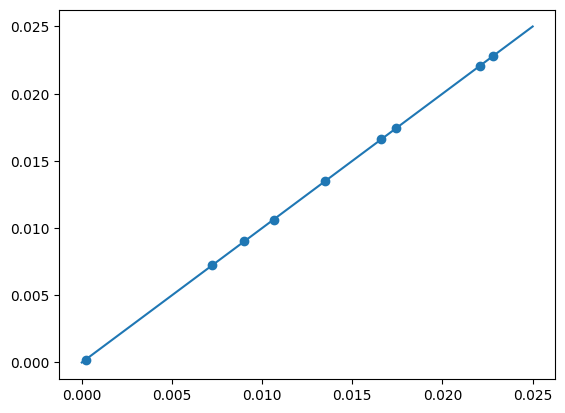

In [15]:
df = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")
df = df[df["z_dist_est"] >= 0.02]

bins_ = np.linspace(0.02, 0.055, 10)
bin_labels = list(range(1, len(bins_)))

df["bin_label"] = pd.cut(df["z_dist_est"], bins_, labels=bin_labels)

df_grouped = df.groupby(by='bin_label', observed=False).agg(
    N_data=('logdist_combined_fp', 'count'),
    z=('z_dist_est', 'median'),
    logdist_mean=('logdist_combined_fp', 'mean'),
    logdist_median=('logdist_combined_fp', 'median'),
    logdist_std=('logdist_combined_fp', 'std')
)
bin_center = 0.5 * (bins_[:1] + bins_[1:])

# Calculate stderr
df_grouped["logdist_stderr"] = df_grouped["logdist_std"] / np.sqrt(df_grouped["N_data"])


#### Use bin_data
x = df["z_dist_est"].to_numpy()
y = df["logdist_combined_fp"].to_numpy()

x_bin, y_median_bin, y_err_bin, y_stderr_bin = bin_data_median(x=x, y=y, xmin=0.02, xmax=0.055, n_bin=10)

plt.scatter(df_grouped["logdist_median"], y_bin)
plt.plot([0., 0.025], [0., 0.025])

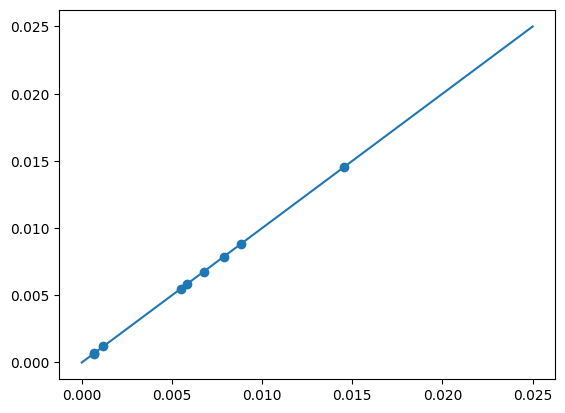

In [16]:
df = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")
df = df[df["z_dist_est"] >= 0.02]

bins_ = np.linspace(0.02, 0.055, 10)
bin_labels = list(range(1, len(bins_)))

df["bin_label"] = pd.cut(df["z_dist_est"], bins_, labels=bin_labels)

df_grouped = df.groupby(by='bin_label', observed=False).agg(
    N_data=('logdist_combined_fp', 'count'),
    z=('z_dist_est', 'median'),
    logdist_mean=('logdist_combined_fp', 'mean'),
    logdist_median=('logdist_combined_fp', 'median'),
    logdist_std=('logdist_combined_fp', 'std')
)
bin_center = 0.5 * (bins_[:1] + bins_[1:])

# Calculate stderr
df_grouped["logdist_stderr"] = df_grouped["logdist_std"] / np.sqrt(df_grouped["N_data"])


#### Use bin_data
x = df["z_dist_est"].to_numpy()
y = df["logdist_combined_fp"].to_numpy()
yerr = df["logdist_err_combined_fp"].to_numpy()

x_bin, y_mean_bin, y_err_bin, y_stderr_bin = bin_data(x=x, y=y, xmin=0.02, xmax=0.055, n_bin=10)

plt.scatter(df_grouped["logdist_mean"], y_mean_bin)
plt.plot([0., 0.025], [0., 0.025])

## Error-weighted mean from pandas vs bin_data

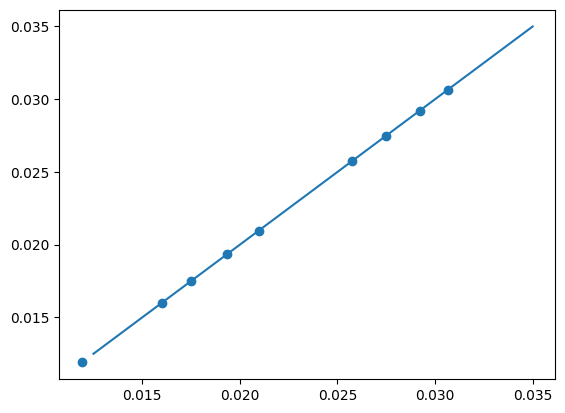

In [20]:
df = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")
df = df[df["z_dist_est"] >= 0.02]

# Weight
df["w"] = 1 / df["logdist_err_combined_fp"]**2
df["w_times_logdist"] = df["w"] * df["logdist_combined_fp"]

bins_ = np.linspace(0.02, 0.055, 10)
bin_labels = list(range(1, len(bins_)))

df["bin_label"] = pd.cut(df["z_dist_est"], bins_, labels=bin_labels)

df_grouped = df.groupby(by='bin_label', observed=False).agg(
    N_data=('logdist_combined_fp', 'count'),
    z=('z_dist_est', 'median'),
    logdist_mean=('logdist_combined_fp', 'mean'),
    logdist_median=('logdist_combined_fp', 'median'),
    logdist_std=('logdist_combined_fp', 'std'),
    numerator=('w_times_logdist', 'sum'),
    denominator=('w', 'sum')
)
bin_center = 0.5 * (bins_[:1] + bins_[1:])

# Calculate stderr
df_grouped["logdist_stderr"] = df_grouped["logdist_std"] / np.sqrt(df_grouped["N_data"])
df_grouped["logdist_ew"] = df_grouped["numerator"] / df_grouped["denominator"]


#### Use bin_data
x = df["z_dist_est"].to_numpy()
y = df["logdist_combined_fp"].to_numpy()
yerr = df["logdist_err_combined_fp"].to_numpy()

x_bin, y_ew_bin, y_err_bin, y_stderr_bin = bin_data_error_weighting(x=x, y=y, yerr=yerr, xmin=0.02, xmax=0.055, n_bin=10)



plt.scatter(df_grouped["logdist_ew"], y_ew_bin)
plt.plot([0.0125, 0.035], [0.0125, 0.035])
# plt.scatter(bin_center, df_grouped["logdist_mean"], c="r", label="mean")
# plt.scatter(bin_center, df_grouped["logdist_median"], c="b", label="median")
# plt.legend()

Mean:  0.0006513708964641144
Median:  0.01063441701361155


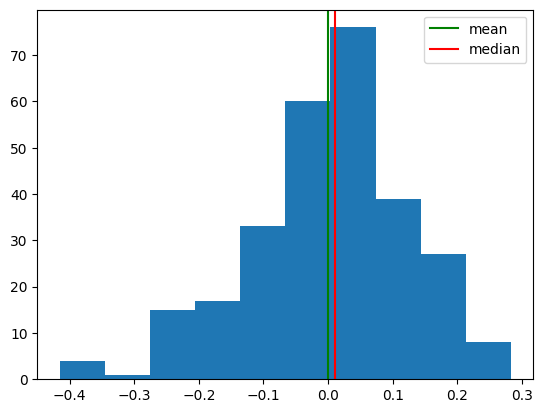

In [39]:
df = df[df["bin_label"] == 1]

logdist_mean = df["logdist_combined_fp"].mean()
logdist_median = df["logdist_combined_fp"].median()

print("Mean: ", logdist_mean)
print("Median: ", logdist_median)

plt.axvline(logdist_mean, c='g', label="mean")
plt.axvline(logdist_median, c='r', label="median")

plt.hist(df["logdist_combined_fp"])
plt.legend()

Negatively skewed -> mean always pull towards more negative values (NO!!!)

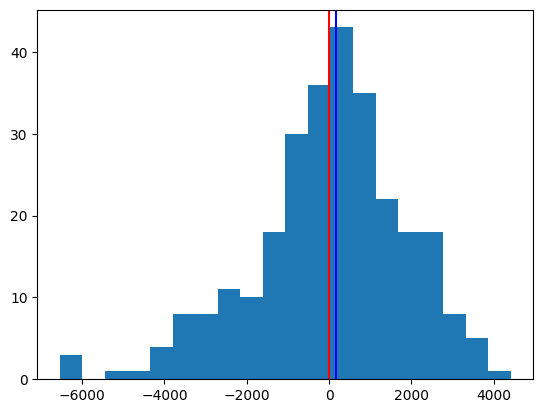

In [33]:
df = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")
df = df[df["z_dist_est"] >= 0.02]

bins_ = np.linspace(0.02, 0.055, 10)
bin_labels = list(range(1, len(bins_)))

df["bin_label"] = pd.cut(df["z_dist_est"], bins_, labels=bin_labels)
df = df[df["bin_label"] == 1]

# Calculate peculiar velocity estimator
pv = LightSpeed * df["z_dist_est"] * df["logdist_combined_fp"] * np.log(10) / (1 + epsilon * df["z_dist_est"])
# pv_err = LightSpeed * x_bin * y_bin_stderr * np.log(10) / (1 + epsilon * x_bin)

plt.hist(pv, bins=20)
plt.axvline(x=pv.mean(), c='r')
plt.axvline(x=pv.median(), c='b')
# plt.scatter(bin_center, df_grouped["logdist_mean"], c="r", label="mean")
# plt.scatter(bin_center, df_grouped["logdist_median"], c="b", label="median")
# plt.legend()

plt.show()